In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import contractions
from bs4 import BeautifulSoup
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter

import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Loading the Dataset
The first step is to load the dataset and look at its structure. \
The shape of the dataset shows that there are 6 columns and 1024 rows. This means we have 1024 headlines.\
For the sentiment analysis purpose, we make use of the columns **Headline** and **Sentiment**. \
The dataset contains 5 categories of sentiments:
- -1.0 (highly negative) 
- -0.5 (moderately negative)
- 0.0 (neutral)
- 0.5 (moderately positive)
- 1.0 (highly positive)

However, the sentiments are reduced to only 
- 0 (negative)
- 1 (neutral)
- 2 (positive) 

categories for this project.


In [100]:
#load data
df = pd.read_csv("climate_headlines_sentiment.csv")
print('The shape of the dataset:',df.shape)
df.head()

The shape of the dataset: (1024, 6)


,Unnamed: 0,Headline,Link,Content,Sentiment,Justification
0,0,Australia's year ahead in climate and environm...,https://www.abc.net.au/news/science/2024-01-23...,The year has barely started and extreme weath...,0.0,The headline is unclear about its direct impac...
1,1,Projections reveal the vulnerability of freshw...,https://news.griffith.edu.au/2024/01/09/projec...,"“Water from groundwater, rivers and rainfall ...",-0.5,The vulnerability of freshwater is concerning ...
2,2,"Record heat in 2023 worsened global droughts, ...",https://www.anu.edu.au/news/all-news/record-he...,2023 saw an increase in the frequency and int...,-1.0,The headline describes worsening environmental...
3,3,"It's not just the total rainfall ""“ why is eas...",https://www.theguardian.com/australia-news/202...,The number of storms in some regions is decre...,0.0,The headline is unclear about its stance on cl...
4,4,Expert Commentary: 2023 was the warmest year o...,https://www.csiro.au/en/news/all/news/2024/jan...,The European Union's Copernicus Climate Chang...,-0.5,While highlighting the reality of climate chan...


# Cleaning the Headlines
Headlines must be cleaned before feeding them to the model, as they may contain numbers, special characters, stop words, and other irrelevant elements that could mislead the model or add no value to classification. It is important to understand the following concepts for the cleaning process: 
- **Stop Words:** Frequently occuring words (such as 'is', 'are', 'the', 'and') that carry no signficant meaning and often removed for natural language processing.
- **Stemming:** The process of reducing words to their base foem by removing suffixes. For example: going $\rightarrow$ go, happily $\rightarrow$ happi
- **Lemmatization:** This process converts words to their lemma, or dictionary form. Unlike stemmer, lemmatizer can discriminate between words which have different meanings depending on part of speech (POS). For example: "meeting" in "This will be our final meeting." remains unchanged while that in "We will be meeting again tomorrow." is reduced to "meet". Similarly, happily $\rightarrow$ happy, is/am/are $\rightarrow$ be. Both of these processes have their pros and cons but we use lemmatization for this project.
- **Part of Speech (POS):** A category of words that have similar grammatical properties. Commonly listed English POS are noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, and determiner.
- **Word Tokenization:** The process of breaking text into individual words.

**Libraries Used:**
1. Tokenization and Lemmatization -> Natural Language Toolkit (NLTK)
2. String Pattern matching and Replacement -> Regular Expression (RegEx/re) 
3. Expansion of Contractions -> Contractions
4. Remove HTML tags (might be present in data but not in this one hence commented in code) -> BeautifulSoup (bs4)

In [101]:
# instantantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# function to map POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    # for adectives
    if tag.startswith('J'):
        return 'a'
    # for verbs
    elif tag.startswith('V'):
        return 'v'
    # for nouns    
    elif tag.startswith('N'):
        return 'n'
    # for adverbs
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

#test example to see how the lemmatizer works
test_text = "I planned this to be our final meeting but it seems like we will be meeting again."
tokens = word_tokenize(test_text)
tags = pos_tag(tokens)
print([(word,tags) for word,tags in tags])
print([(word, get_wordnet_pos(tag)) for word, tag in tags])

text = [
        lemmatizer.lemmatize(word.lower(), pos=get_wordnet_pos(pos))  # Lemmatize word based on POS
        for word, pos in tags
        if len(word) > 2
    ]
print('Original text -> ',test_text)
print('Lemmatized text -> '+' '.join(text))


[('I', 'PRP'), ('planned', 'VBD'), ('this', 'DT'), ('to', 'TO'), ('be', 'VB'), ('our', 'PRP$'), ('final', 'JJ'), ('meeting', 'NN'), ('but', 'CC'), ('it', 'PRP'), ('seems', 'VBZ'), ('like', 'IN'), ('we', 'PRP'), ('will', 'MD'), ('be', 'VB'), ('meeting', 'VBG'), ('again', 'RB'), ('.', '.')]
[('I', 'n'), ('planned', 'v'), ('this', 'n'), ('to', 'n'), ('be', 'v'), ('our', 'n'), ('final', 'a'), ('meeting', 'n'), ('but', 'n'), ('it', 'n'), ('seems', 'v'), ('like', 'n'), ('we', 'n'), ('will', 'n'), ('be', 'v'), ('meeting', 'v'), ('again', 'r'), ('.', 'n')]
Original text ->  I planned this to be our final meeting but it seems like we will be meeting again.
Lemmatized text -> plan this our final meeting but seem like will meet again


In [102]:

#cleaning function
def clean_data(data):
    #expand contractions
    text = contractions.fix(data)
    #remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    #remove HTML tags
    #text = BeautifulSoup(text, "html.parser").get_text()
    #remove numbers
    text = re.sub(r'[0-9]', '', text)
    #remove news reporters
    text = re.sub(r'\s*-\s*[^-]*$', '', text)
    #remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    #remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # tokenize text
    text_tokens = word_tokenize(text)
   
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    text_tokens = [word for word in text_tokens if word.lower() not in stop_words]
    #POS tagging
    pos_tags = pos_tag(text_tokens)
    #lemmatize based on POS and remove stopwords
    text = [
        lemmatizer.lemmatize(word.lower(), pos=get_wordnet_pos(pos))  # Lemmatize word based on POS #mexicos to mexico
        for word, pos in pos_tags 
        if len(word) > 2  # Ensure word length is >1 (remove single characters)
    ]

    #remove the wors that frequently appear in the headlines but are not useful for sentiment analysis
    text = [word for word in text if word.lower() not in ["climate", "change","global","report","usa",
         "india", "germany", "german", "brazil", "canada", "canadian","australia", "france", "french", "european", "europe",
         "mexico", "japan", "china","spain","italy","indian","south","korea","russia", "russian","ukraine","impact","news","world"]]
    #return the cleaned text
    return ' '.join(text)

In [103]:
#clean a sample headline using the clean_data function
i = 4
text = df.loc[i, 'Headline']
print('Original headline -> ',text)
print('Cleaned headline -> ',clean_data(text))

Original headline ->  Expert Commentary: 2023 was the warmest year on record - CSIRO
Cleaned headline ->  expert commentary warm year record


In [104]:
#take the features and targets 
df = df[["Headline","Sentiment"]]
df.head()


,Headline,Sentiment
0,Australia's year ahead in climate and environm...,0.0
1,Projections reveal the vulnerability of freshw...,-0.5
2,"Record heat in 2023 worsened global droughts, ...",-1.0
3,"It's not just the total rainfall ""“ why is eas...",0.0
4,Expert Commentary: 2023 was the warmest year o...,-0.5


In [105]:
#looking for nan values in the target column
for i in range(len(df)):
	if pd.isna(df.loc[i,"Sentiment"]):
		print(f'index {i} has nan value')

index 232 has nan value


In [106]:
print(df.loc[232,"Headline"])
print(df.loc[232,"Sentiment"])

Mexico City is running out of water, forcing many to ration - Axios
nan


In [107]:
# assigning correct sentiment value to the nan value
df.loc[232, "Sentiment"] = -1.0
print(df.loc[232,"Headline"])
print(df.loc[232,"Sentiment"])

Mexico City is running out of water, forcing many to ration - Axios
-1.0


In [108]:
# reduce the sentiment values to 3 classes
label_mapping = {-1.0: 0, -0.5: 0, 0.0: 1, 0.5: 2, 1.0: 2}
df['Int Sentiment'] = df['Sentiment'].replace(label_mapping)
# change the data type of 'Int Sentiment' column to int
df['Int Sentiment'] = df['Int Sentiment'].astype(int)

# Splitting the Dataset
Dataset is usually split followig this scheme: training data -> 60%, cross-validation data -> 20%, and test data -> 20% \
Since the dataset has a small size, the following splitting scheme is followed: training data -> 90%, and test data -> 10%

In [109]:
# clean the headlines using the clean_data function
df["Cleaned Headline"] = df["Headline"].apply(clean_data)

# split the data into training and test set
x_data = df["Cleaned Headline"]
y_data = df["Int Sentiment"]
x_train, x_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
print("Train shape: ",x_train.shape)
print("Test shape: ",x_test.shape)


Train shape:  (921,)
Test shape:  (103,)


# Exploratory Analysis of Words in the Headlines
Before building a model to predict the sentiment expressed by a news headline, an exploratory analysis can be done on the dataset to see the proportion of sentiments across each category, assess if headline lengths are related to a particular sentiment, and analyze the frequency of the words in the headlines to weed out words that show up in all categories and retain the words that appear only in a specific category. Following can be observed:
- There are about half as many neutral sentiment headlines as there are positive or negative ones.
- Before cleaning, small and medium-length headlines are mostly neutral, whereas long headlines are predominantly positive or negative, with a much smaller proportion being neutral. After cleaning, most small headlines are neutral, while medium and longer headlines are predominantly either negative or positive.
- It can be seen from the box plot that the median length of neutral headines is much lower than that of positive and negative ones. The dots outside the whiskers represent the outliers.
- From the word clouds and word frequency distributions, it can be observed that words such as 'flood,' 'drought,' 'record,' and 'warm' frequently appear in negative headlines. In contrast, words like 'energy,' 'transition,' 'policy,' 'action,' 'goal,' and 'target' are common in positive headlines. Neutral headlines' most repeated words are mostly present in positive headines. 
- Certain words like **climate change** and **name of countries** are removed using the *clean_data* function as they frequently appear across all sentiment categories.


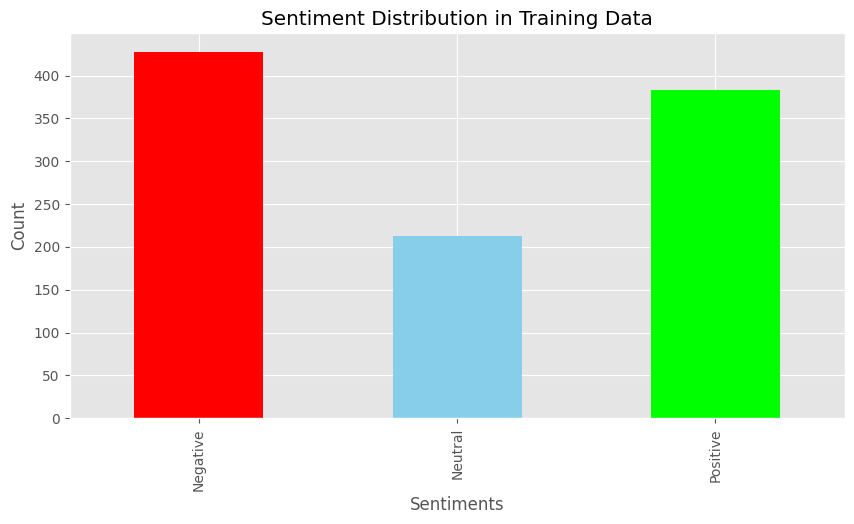

In [110]:

#Analyzing senntiment counts in training data
plt.style.use('ggplot')
ax = y_data.value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(10,5),
          color=['red', 'skyblue', 'lime'],)
ax.set_xlabel('Sentiments')
ax.set_ylabel('Count')

# adding custom x-axis labels
ax.set_xticks(range(3))  # as y_train has values [0, 1, 2]
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])

ax.set_title('Sentiment Distribution in Training Data')

plt.show()

In [111]:
# function to create a list of the lengths of headlines for a given sentiment
def create_lengths_list(data_x, data_y, sentiment):
    text_lengths = [len(text) for i, text in enumerate(data_x) \
                    if data_y.iloc[i]==sentiment] #enumerate returns the index and the value
    return text_lengths 

# function to plot the histogram for headline lengths
def plot_headline_length_distribution(data_x, data_y, title):
    # create a list of text lengths for each sentiment
    text_lengths_neg = create_lengths_list(data_x, data_y,0)
    text_lengths_neutral = create_lengths_list(data_x, data_y,1)
    text_lengths_pos = create_lengths_list(data_x, data_y,2)
    # plot the histogram
    plt.hist([text_lengths_neg, text_lengths_neutral, text_lengths_pos], \
    bins=15, range=(10, 80), density=True, label=['negative', 'neutral','positive'])
    plt.xlabel('Headline Length')  
    plt.ylabel('Frequency')
    plt.title(title)  
    plt.legend(title='Label') 
    plt.figure(figsize=(10, 5))
    plt.show()

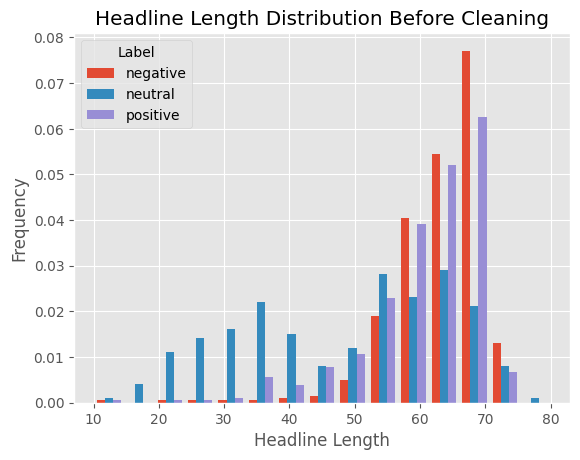

<Figure size 1000x500 with 0 Axes>

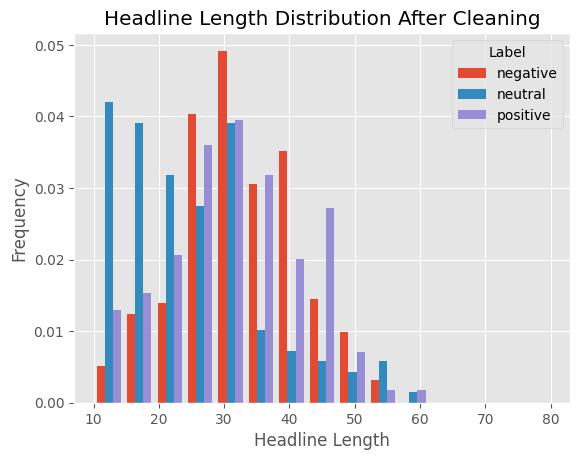

<Figure size 1000x500 with 0 Axes>

In [112]:
#plot the headline length distributions
plot_headline_length_distribution(df["Headline"], y_data, "Headline Length Distribution Before Cleaning")
plot_headline_length_distribution(x_data, y_data, "Headline Length Distribution After Cleaning") 

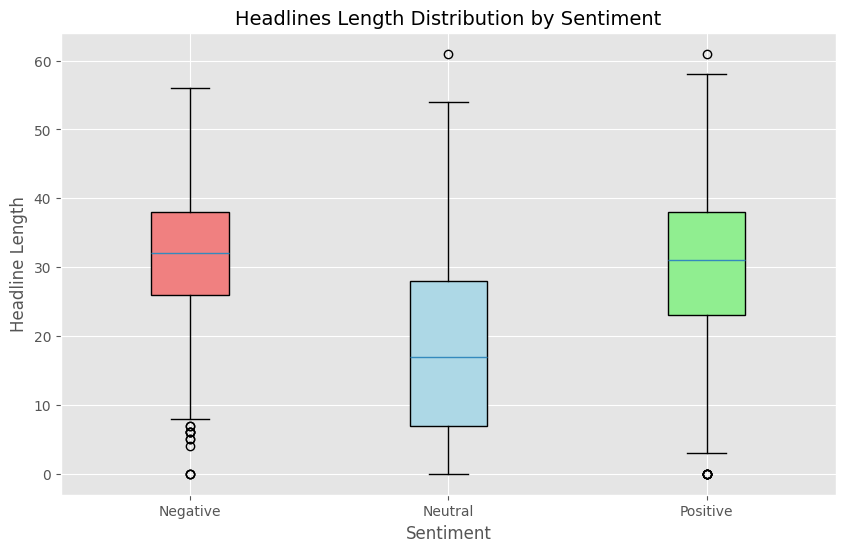

In [113]:
# get the headlines lengths list for box plot
text_lengths_neg = create_lengths_list(x_data, y_data,0)
text_lengths_neu = create_lengths_list(x_data, y_data,1)
text_lengths_pos = create_lengths_list(x_data, y_data,2)

# data for the box plot
data = [text_lengths_neg, text_lengths_neu, text_lengths_pos]

# create the box plot
plt.figure(figsize=(10, 6))
box = plt.boxplot(data, patch_artist=True, tick_labels=['Negative', 'Neutral', 'Positive'])

# set different color for each box
colors = ['lightcoral', 'lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# set titles and axis labels
plt.title('Headlines Length Distribution by Sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Headline Length', fontsize=12)
plt.grid(axis='y', linestyle='-')

plt.show()

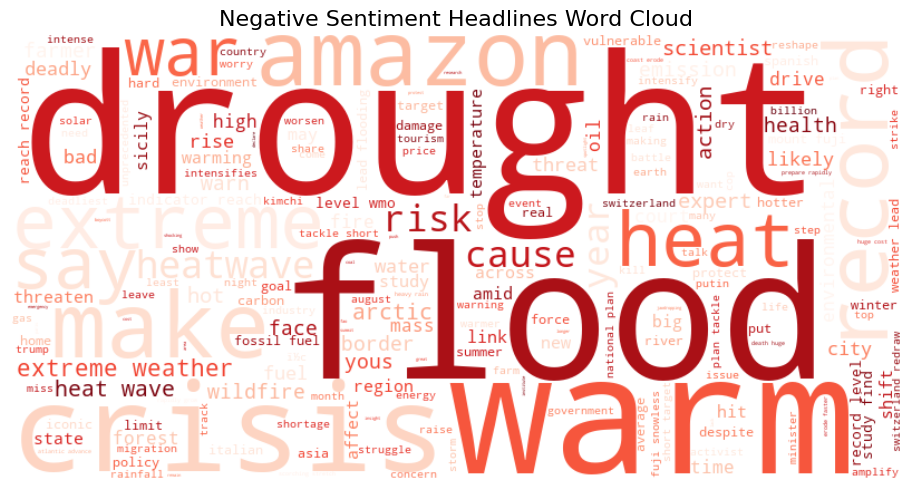

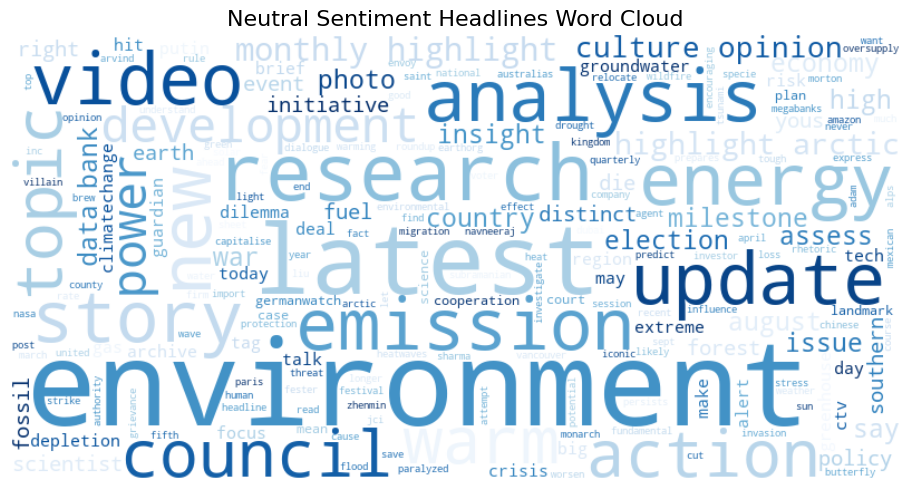

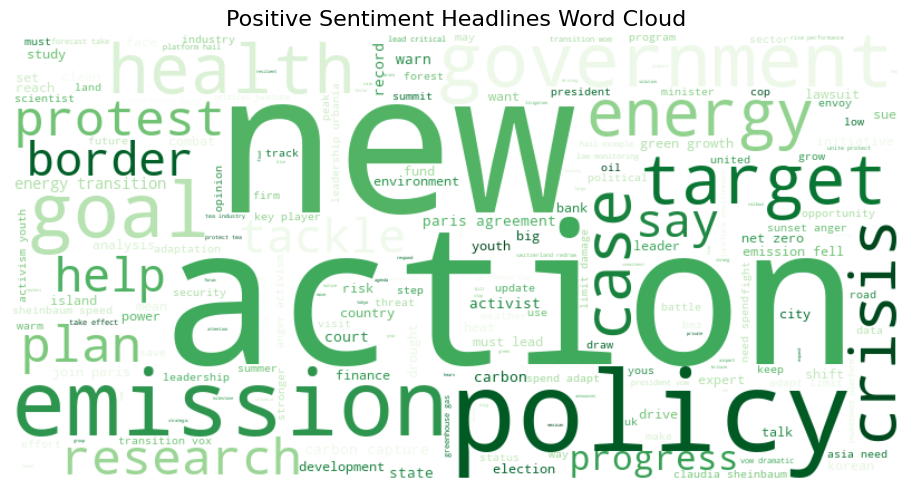

In [114]:
# define color schemes and headings for each sentiment
sentiment_categories = [0, 1, 2]
titles = ["Negative Sentiment Headlines Word Cloud", 
          "Neutral Sentiment Headlines Word Cloud", 
          "Positive Sentiment Headlines Word Cloud"]
color_schemes = ["Reds", "Blues", "Greens"]  # Different colormap for each sentiment

# generate word clouds for each sentiment category
wordclouds = {}
for sentiment, color in zip(sentiment_categories, color_schemes):
    text = " ".join(x_train[y_train == sentiment])
    wordclouds[sentiment] = WordCloud(width=800, 
                                      height=400, 
                                      background_color='white', 
                                      colormap=color).generate(text)

# plot the word clouds
for sentiment in sentiment_categories:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordclouds[sentiment], interpolation='bilinear')
    plt.title(titles[sentiment], fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [116]:
#function to get words frequency
def get_words_frequency(texts):
    word_frequency = Counter()
    for text in texts:
        words = text.split()
        word_frequency.update(words)
    return word_frequency #returns a dictionary with word frequencies

#function to get most common words
def sentiment_specific_common_words(texts,sentiments,sentiment_value,num_words=15):
    headlines = texts[sentiments == sentiment_value]
    word_frequency = get_words_frequency(headlines)
    most_common_words = word_frequency.most_common(num_words) #a list of tuples with word and frequency
    return zip(*most_common_words) # * unpacks the list into tuples; zip groups the first elements of each tuple together and the second elements together

#function to plot the bar chart for the most common words
def plot_words_frequency(texts, sentiments, sentiment_value, bar_color):
    words, frequencies = sentiment_specific_common_words(texts, sentiments, sentiment_value)
    #convert the tuples to lists for plotting
    words = list(words)
    frequencies = list(frequencies)
    #plot
    plt.figure(figsize=(6, 3))
    plt.bar(words, frequencies, color=bar_color)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Most Common Words in Sentiment {sentiment_value}')
    plt.xticks(rotation=45)
    plt.show()

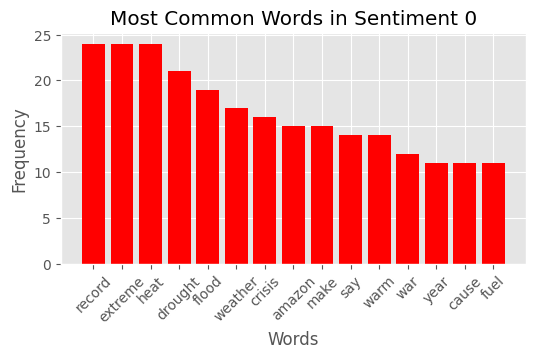

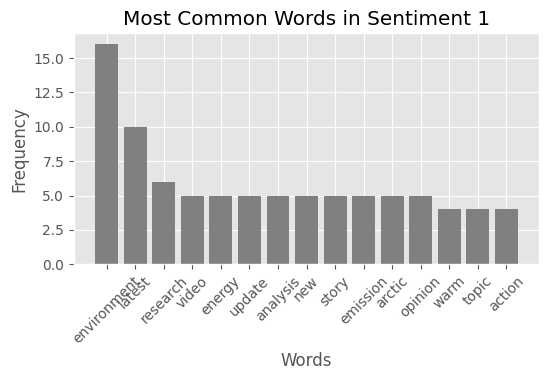

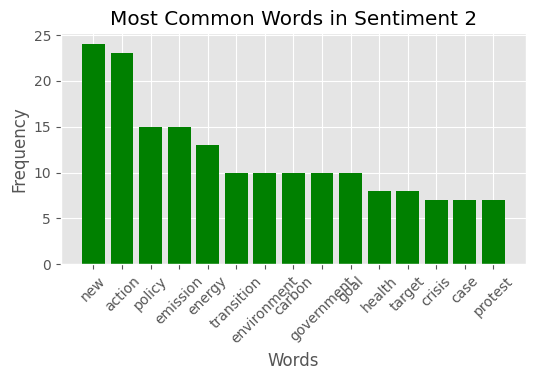

In [117]:
sentiment_colors = {
    0: 'red',          # High Negative
   # 1: 'lightcoral', # Moderate Negative
    1: 'gray',          # Neutral
    #3: 'lightgreen',  # Moderate Positive
    2: 'green'          # High Positive
}

# plot the word frequency distribution
for sentiment_value, color in sentiment_colors.items():
    plot_words_frequency(x_train, y_train, sentiment_value,color)


# Creating a Baseline Model
A baseline model is essential as it establishes a simple benchmark for comparison, helping us evaluate the effectiveness of more complex models. Any model must outperform the baseline to be considered useful.

In this baseline model, predictions are made with probabilities of $\frac{2}{5}$ for positive and negative sentiments and $\frac{1}{5}$ for neutral sentiment. This simple approach assumes a weighted random guess based on the observed distribution of sentiment categories.

# Evaluation Mterics
Evaluation metrics are tools to measure the performance of a model. They allow us to quantify how well a model predicts outcomes and identify areas for improvement. Different metrics capture various aspects of performance, such as overall correctness, ability to identify specific classes, or handling imbalanced datasets.
- **Accuracy:** The ratio of correct predictions to the total number of predictions. \
$Accuracy=\frac{True \hspace{0.1cm} Positives \hspace{0.1cm} + \hspace{0.1cm} True \hspace{0.1cm} Negatives}{Total \hspace{0.1cm}Predictions}$ \
A higher accuracy indicates that the model predicts correctly more often, but it may not always be sufficient for imbalanced datasets.

- **Precision:** The ratio of true positive predictions to all positive predictions.\
$Precision=\frac{True \hspace{0.1cm} Positives}{True \hspace{0.1cm}Positives\hspace{0.1cm}+\hspace{0.1cm}False\hspace{0.1cm}Positives}$ \
Precision is crucial when false positives have significant consequences, as it reflects how specific the model is in identifying positive cases.

- **Recall (Sensitivity):** The ratio of true positive predictions to the total actual positives.\
$Recall=\frac{True \hspace{0.1cm} Positives}{True \hspace{0.1cm}Positives\hspace{0.1cm}+\hspace{0.1cm}False\hspace{0.1cm}Negatives}$ \
Recall is essential when missing positive cases (false negatives) is costly, such as in medical diagnosis.

- **$F_1$ Score:** The harmonic mean of precision and recall.\
$F_1 \hspace{0.1cm} \text{score} = 2 \times \frac{\text{Precision} \hspace{0.1cm} \times \hspace{0.1cm} \text{Recall}}{\text{Precision} \hspace{0.1cm} + \hspace{0.1cm} \text{Recall}}$\
The $F_1$ score is particularly useful when there is a trade-off between precision and recall or in imbalanced datasets.

# Evaluation of the Baseline Model

The baseline model shows an accuracy of **0.35** on the training set and **0.36** on the test set. It performs best on negative sentiment (precision 0.40, recall 0.37) but struggles with neutral sentiment (precision 0.26, recall 0.25). On the test set, performance drops for neutral sentiment (precision 0.10, recall 0.11), while negative and positive sentiments are predicted with higher precision and recall.

In [118]:
# Set a random seed for reproducibility
random.seed(42)

# Function to randomly assign one of the target values to each input
sentiment_categories = [0,1,2]
weights = [2, 1, 2]  # Probabilities proportional to 2/5, 1/5, and 2/5

def random_baseline_model(num_samples):
    return random.choices(sentiment_categories, weights=weights, k=num_samples)

#model predictions
y_train_pred = random_baseline_model(len(y_train))
y_test_pred = random_baseline_model(len(y_test))

#metrics for training predictions
print("For Training:")
print(classification_report(y_train, y_train_pred))
#metrics for test predictions
print("For Test:")
print(classification_report(y_test, y_test_pred))

For Training:
              precision    recall  f1-score   support

           0       0.40      0.37      0.38       379
           1       0.26      0.25      0.26       194
           2       0.36      0.39      0.37       348

    accuracy                           0.35       921
   macro avg       0.34      0.34      0.34       921
weighted avg       0.35      0.35      0.35       921

For Test:
              precision    recall  f1-score   support

           0       0.54      0.41      0.47        49
           1       0.10      0.11      0.10        19
           2       0.33      0.43      0.38        35

    accuracy                           0.36       103
   macro avg       0.32      0.31      0.31       103
weighted avg       0.39      0.36      0.37       103



In [320]:
#Constructing Tokenizer class
t = Tokenizer() #Tokenizer class constructor for training documents

#Fitting Tokenizer to the train data
t.fit_on_texts(x_train)

def pad_data(sequences, max_length):

  # Integer encode the documents
  encoded_docs = t.texts_to_sequences(sequences)
  # Pad documents to a max length of 65 words)
  padded_data = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_data

x_train_padded = pad_data(x_train, 70)
x_test_padded = pad_data(x_test, 70) 
print(x_train_padded)

[[ 278  209  210 ...    0    0    0]
 [ 119  653  431 ...    0    0    0]
 [ 280  654    0 ...    0    0    0]
 ...
 [  76    2  133 ...    0    0    0]
 [ 120 1384    8 ...    0    0    0]
 [  12    0    0 ...    0    0    0]]


In [321]:
# Calculate the vocabulary size, which is the length of word_index plus 1
# The additional 1 is for reserving an integer value for out-of-vocabulary words
vocab_size = len(t.word_index) + 1   
print("The training set vocab size is "+ str(vocab_size))


The training set vocab size is 1386


# Building a Model and Tuning the Hyperparameters



In [322]:
def build_model(vocab_size, embedding_dim, neuron, lambda_val):
    keras.backend.clear_session()
    keras.utils.set_random_seed(0)
    
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Flatten(),
        Dense(units=neuron, activation='relu', kernel_regularizer=regularizers.l2(lambda_val)),
        Dense(units=3, activation='linear')
    ])
    
    # Compile the model
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
        optimizer=keras.optimizers.Adam(learning_rate=0.001)
    )
    
    return model

In [270]:
def plot_history(history, parameter, title):
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="test", marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(range(0, len(history['loss']) + 1))
  plt.title(f"{title} = {parameter}")
  plt.legend()
  plt.show()


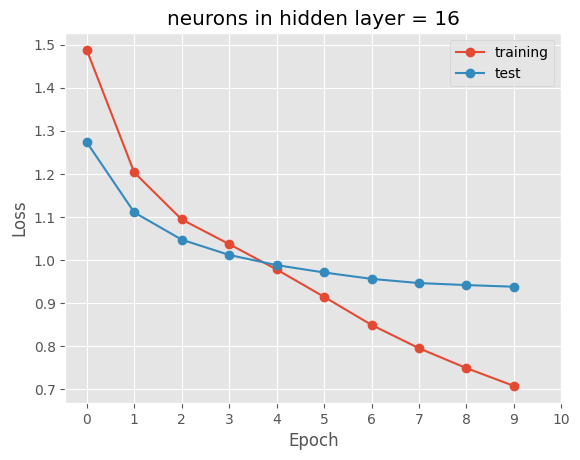

Train Accuracy: 0.80, Test Accuracy: 0.61


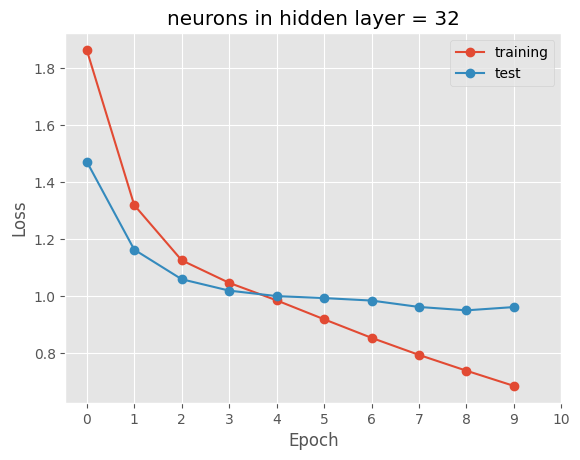

Train Accuracy: 0.83, Test Accuracy: 0.64


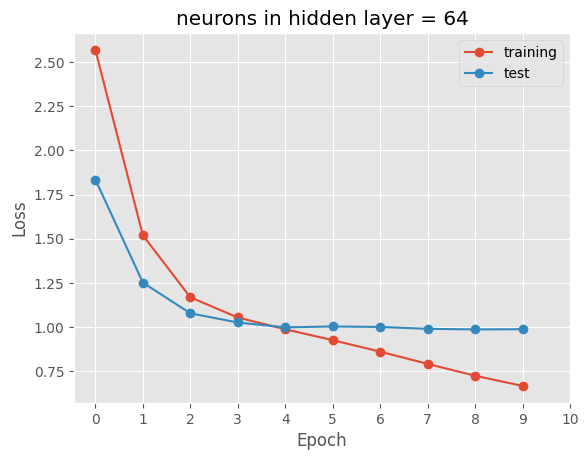

Train Accuracy: 0.84, Test Accuracy: 0.61


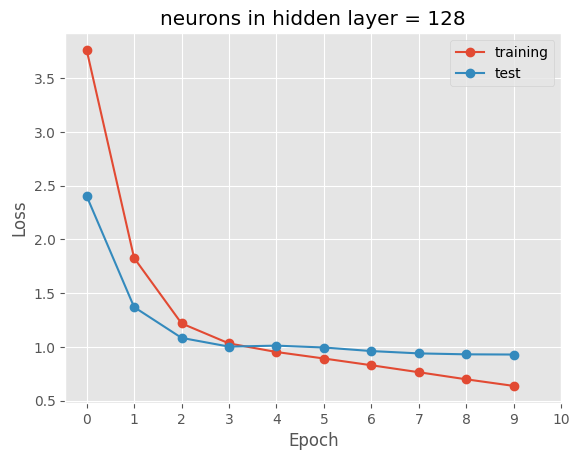

Train Accuracy: 0.87, Test Accuracy: 0.69


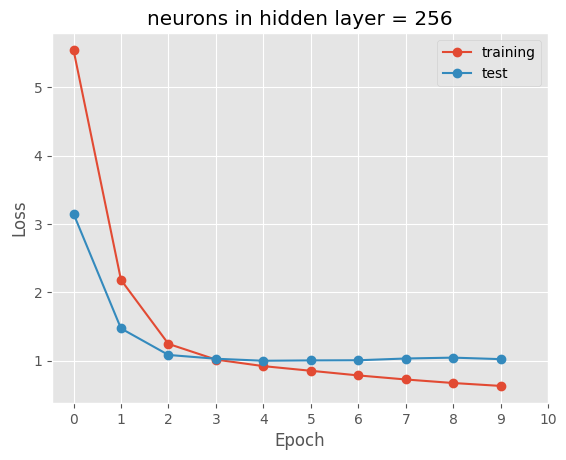

Train Accuracy: 0.85, Test Accuracy: 0.57


In [323]:
#Trying different neuron numbers in the hidden layer
neuronsss = [16, 32, 64, 128, 256]
embedding_dim = 10
epochs = 10
for neuron in neuronsss:
   model = build_model(vocab_size, embedding_dim, neuron,0.02)
   history = model.fit(x_train_padded, y_train, validation_data=(x_test_padded, y_test), epochs=epochs, verbose=0)  
   history = pd.DataFrame(history.history)
   plot_history(history,neuron,'neurons in hidden layer')
   plt.show()
   train_accuracy = history['accuracy'].iloc[-1]
   test_accuracy = history['val_accuracy'].iloc[-1]
   print(f"Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")


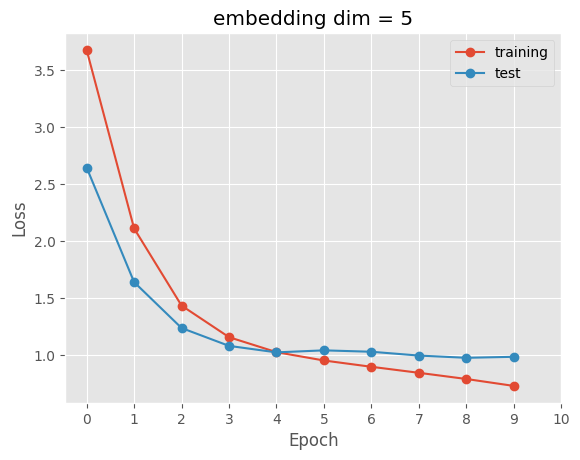

Train Accuracy: 0.81, Test Accuracy: 0.57


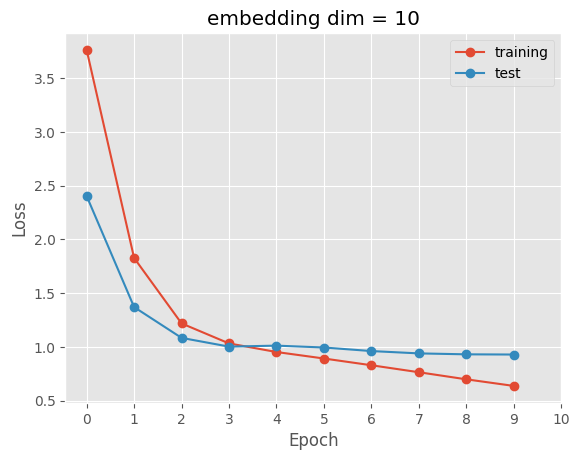

Train Accuracy: 0.87, Test Accuracy: 0.69


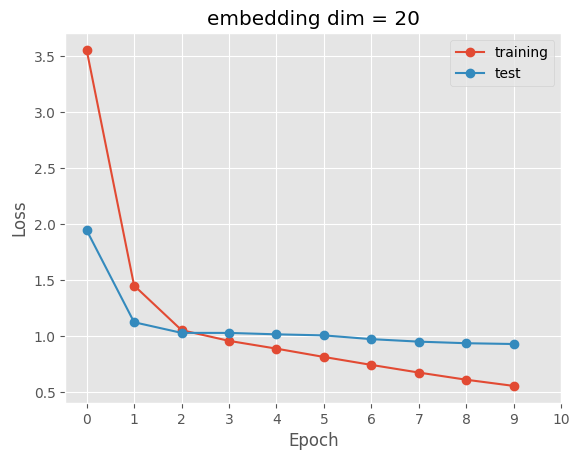

Train Accuracy: 0.89, Test Accuracy: 0.65


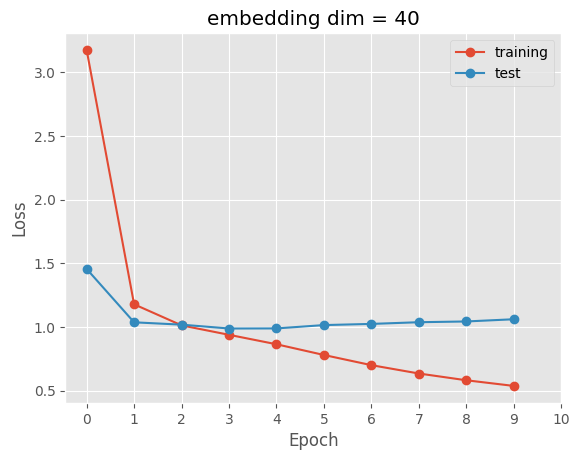

Train Accuracy: 0.89, Test Accuracy: 0.57


In [324]:
#Trying different embedding dimensions
emb_dim = [5,10,20,40]
neuron = 128    
lam = 0.02
for em in emb_dim:
    model = build_model(vocab_size, em,neuron, lam)
    history = model.fit(x_train_padded, y_train, validation_data=(x_test_padded, y_test), epochs=epochs, verbose=0)  
    history = pd.DataFrame(history.history)
    plot_history(history,em,'embedding dim')
    plt.show()
    train_accuracy = history['accuracy'].iloc[-1]
    val_accuracy = history['val_accuracy'].iloc[-1]
    print(f"Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {val_accuracy:.2f}")   

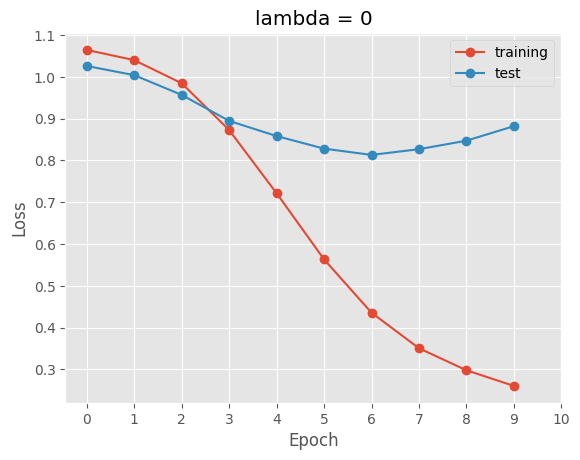

lambda: 0 - Train Accuracy: 0.91, Test Accuracy: 0.60


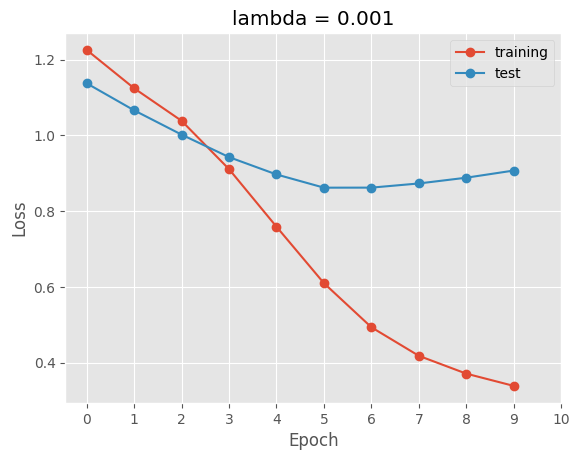

lambda: 0.001 - Train Accuracy: 0.91, Test Accuracy: 0.61


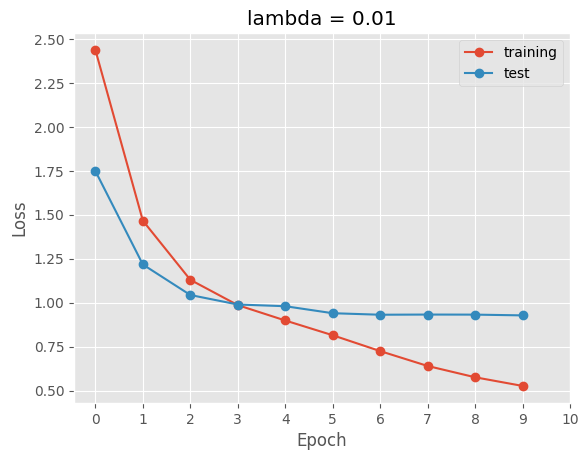

lambda: 0.01 - Train Accuracy: 0.89, Test Accuracy: 0.63


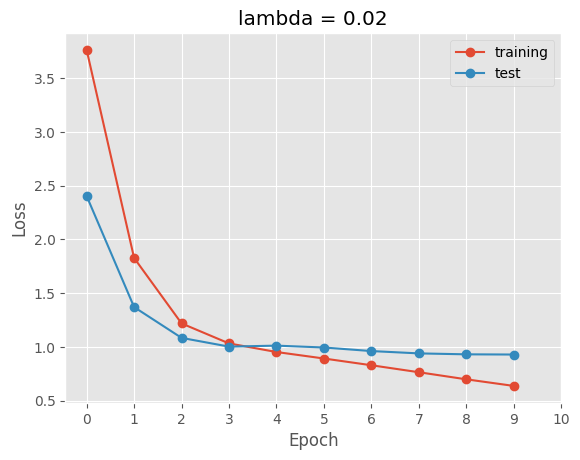

lambda: 0.02 - Train Accuracy: 0.87, Test Accuracy: 0.69


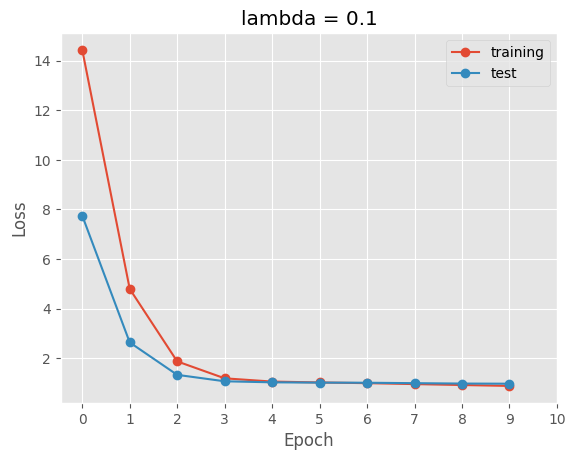

lambda: 0.1 - Train Accuracy: 0.70, Test Accuracy: 0.58


In [325]:
#Trying different regularization parameters
lams = [0,0.001,0.01,0.02, 0.1]
embedding_dim = 10
neuron = 128
epochs = 10
for lam in lams:
   model = build_model(vocab_size, embedding_dim, neuron, lam)
   history = model.fit(x_train_padded, y_train, validation_data=(x_test_padded, y_test), epochs=epochs, verbose=0)  
   history = pd.DataFrame(history.history)
   plot_history(history,lam,'lambda')
   plt.show()
   train_accuracy = history['accuracy'].iloc[-1]
   test_accuracy = history['val_accuracy'].iloc[-1]
   print(f"lambda: {lam} - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")


In [326]:
#Final model
lam = 0.02
embedding_dim = 10
neuron = 128
epochs = 10
model = build_model(vocab_size, embedding_dim, neuron, lam)
history = model.fit(x_train_padded, y_train, validation_data=(x_test_padded, y_test), epochs=epochs, verbose=0)  
history = pd.DataFrame(history.history)
train_accuracy = history['accuracy'].iloc[-1]
test_accuracy = history['val_accuracy'].iloc[-1]
print(f"Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 0.87, Test Accuracy: 0.69


In [327]:
# predict using the trained model on the test data
test_predictions = model.predict(x_test_padded)

# get the predicted class labels by selecting the class with the highest score
predicted_sentiments = np.argmax(test_predictions, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [328]:

# print classification report
print(classification_report(y_test, predicted_sentiments))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77        49
           1       0.67      0.53      0.59        19
           2       0.59      0.69      0.63        35

    accuracy                           0.69       103
   macro avg       0.68      0.66      0.66       103
weighted avg       0.70      0.69      0.69       103



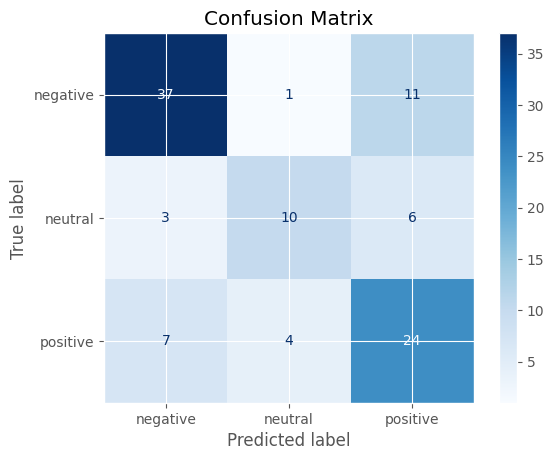

In [329]:

sentiment_categories = [0, 1, 2]
cm = confusion_matrix(y_test, predicted_sentiments, labels=sentiment_categories)
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()